In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import math
import torchtext
import datasets
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
import os

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import cm

# Study 1: Transformation and Diffusion of Global and Task-Specific Representations

## Step 1: Generate BERT and LSTM Embeddings

### 1.1 Data Preprocessing

In [ ]:
from datasets import load_dataset
dataset = load_dataset("SetFit/emotion")
print(dataset)
print(dataset['train'][88]['text'])

Using custom data configuration SetFit--emotion-e444b7640ce3116e
Found cached dataset json (/home/sbkim/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})
i feel so worthless during those times i was struggling finding work


In [ ]:
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
tokenizer = get_tokenizer("basic_english") ## We'll use tokenizer available from PyTorch
global_vectors = GloVe(name='6B', dim=300)

In [ ]:
embedding_list = []
for text in dataset['train']['text']:
    embedding_list.append(global_vectors.get_vecs_by_tokens(tokenizer(text), lower_case_backup=True))
for text in dataset['validation']['text']:
    embedding_list.append(global_vectors.get_vecs_by_tokens(tokenizer(text), lower_case_backup=True))
for text in dataset['test']['text']:
    embedding_list.append(global_vectors.get_vecs_by_tokens(tokenizer(text), lower_case_backup=True))

In [ ]:
from torch.nn.utils.rnn import pad_sequence
inputs = pad_sequence(embedding_list,batch_first=True)

In [ ]:
#np.save("npy/padded_nlp_inputs",inputs)
#load keypoint input array from local 
inputs= np.load("npy/padded_nlp_inputs.npy", allow_pickle = True)
inputs.shape

(20000, 66, 300)

### 1.2 Gererate BERT Embeddings

####  1.2.1 Pretrained Word Embeddings

In [ ]:
#pad/ trim all input data to same length
pad_size = 66
def padding(input_type, dim):
    pad = lambda a,i : a[0:i] if len(a) >= i else np.concatenate((a, [[0]*dim] * (i-len(a))))
    #valid = []
    pad_frames = [ ]
    for i in input_type:
        if len(i)!=0:
            pad_frames.append(pad(i, pad_size))
            #valid.append(1)
        else:
            pad_frames.append(np.zeros((66, 300)))
    return pad_frames

In [ ]:
pretrain = padding(inputs, 300)

In [ ]:
#np.save("npy/valid_set_autoencoder",pretrain)
pretrain= np.load("npy/valid_set_autoencoder.npy", allow_pickle = True)
pretrain.shape

(20000, 66, 300)

#### 1.2.2 Generate BERT Sentence Embeddings

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
from transformers import AutoTokenizer, AutoModel

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)

def get_bert_embeddings(sentences, batch_size=32):
    # Split the sentences into batches
    batches = [sentences[i:i + batch_size] for i in range(0, len(sentences), batch_size)]

    # Initialize a list to store the embeddings for all sentences
    all_embeddings = []

    # Process each batch
    for batch in batches:
        # Tokenize input sentences
        tokenized = bert_tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
        # Move tokenized data to device
        tokenized = tokenized.to(device)
        # Generate BERT embeddings
        with torch.no_grad():
            outputs = model(**tokenized)
            embeddings = outputs.last_hidden_state
        # Extract the [CLS] token embeddings
        sentence_embeddings = embeddings[:, 0, :]
        # Move embeddings to CPU and convert to a list
        sentence_embeddings = sentence_embeddings.to('cpu').detach().numpy().tolist()
        all_embeddings.extend(sentence_embeddings)

    return all_embeddings

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sentences = dataset['train']['text'] + dataset['validation']['text'] + dataset['test']['text']
#embeddings = get_bert_embeddings(sentences)
#embeddings = embeddings.to('cpu').detach().numpy().tolist()
#np.save("npy/bert_embeddings",embeddings)
bert_embeddings= np.load("npy/bert_embeddings.npy", allow_pickle = True)
bert_embeddings.shape

(20000, 768)

### 1.3 Generate RNN-LSTM Embeddings

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.layer_num = layer_num
        self.lstm = nn.LSTM(input_dim,hidden_dim,layer_num,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_dim)
        self.bn = nn.BatchNorm1d(pad_size)
        self.lstm_array = []
        
    def forward(self,inputs):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_num, inputs.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.layer_num, inputs.size(0), self.hidden_dim).requires_grad_()
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        #out = F.leaky_relu(hn)
        self.lstm_array = lstm_out
        out = self.fc(lstm_out[:,-1,:])
        return out

n_hidden = 300
n_joints = 300
n_categories = 6
n_layer = 1
model = LSTM(n_joints,n_hidden,n_categories,n_layer)
model.to(device)

LSTM(
  (lstm): LSTM(300, 300, batch_first=True)
  (fc): Linear(in_features=300, out_features=6, bias=True)
  (bn): BatchNorm1d(66, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
def test(model, test_dl):
    loss = 0
    correct = 0
    accuracy = 0

    target_true = 0
    predicted_true = 0
    correct_true = 0
    
    for step, batch in enumerate(test_dl):
        X, B, y = tuple(t for t in batch)
        output = model(X)
        loss += nn.CrossEntropyLoss()(output, y)
        pred = output.data.max(1)[1]
        correct += pred.eq(y.data).sum()
    
        target_true += torch.sum(y)
        predicted_true += torch.sum(pred)
        correct_true += sum(y*pred == 1)
    
    loss /= len(test_dl.dataset)
    accuracy = 100 * correct/len(test_dl.dataset)
    
    recall = correct_true / target_true
    precision = correct_true / predicted_true
    f1_score = 2 * precision * recall / (precision + recall)

    return accuracy, loss, recall, precision, f1_score

def train(model, lr, num_epochs, train_dl, test_dl):
    lstm_arrays = []
    ys = []
    bs = []

    opt = torch.optim.Adam(model.parameters(), lr = lr) 
    
    for epoch in range(1, num_epochs + 1):
        for step, batch in enumerate(train_dl):
            X, B, y = tuple(t for t in batch)
            opt.zero_grad()
            prediction = model(X)
            if epoch == num_epochs:
                lstm_arrays.append(model.lstm_array)
                ys.append(y)
                bs.append(B)
            loss = nn.CrossEntropyLoss()(prediction, y)  
            loss.backward() 
            opt.step()

        test_accuracy, loss, recall, precision, f1_score = test(model, test_dl)
        print(f"Test accuracy at epoch {epoch}: {test_accuracy:.4f}")
    return lstm_arrays, ys, bs

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
def run_model(inputs, sample):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = LSTM(n_joints,n_hidden,n_categories,n_layer)
    model.to(device)

    features = []
    validation_losses = []
    test_losses = []
    validation_accuracies = []
    test_accuracies = []
    test_recalls = []
    test_precisions = []
    test_F1s=[]
    aug_train_data = []
    
    pad_size = inputs.shape[1]
    emb_size = inputs.shape[2]

    for feature in ['class']:
        y = sample['class']
        if sum(y)==0:
            print('no presence of this feature')
        else:
            features.append(feature)
            print(feature)
            #device = torch.device('cpu')
            X = torch.tensor(inputs, dtype=torch.float).to('cuda')
            y = torch.tensor(y, dtype=torch.long).to('cuda')
            B = torch.tensor(bert_embeddings, dtype=torch.float).to('cuda')

            full_dataset=[[X[b], y[b], B[b]] for b in range(len(y))]
            train_size = int(0.8 * len(full_dataset))
            test_size = len(full_dataset) - train_size
            full_train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

            X = list(zip(*full_train_dataset))[0]
            y = list(zip(*full_train_dataset))[1]
            B = list(zip(*full_train_dataset))[2]

            #Oversampling 
            reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), pad_size*emb_size).cpu()
            reshape_b = torch.tensor((torch.stack(B,dim=0)).squeeze(0)).cpu()
            reshape_inputs = [[reshape_x[i], reshape_b[i]] for i in range(len(y))]
            oversample = RandomOverSampler(sampling_strategy='not majority')
            inputs_over, y_over = oversample.fit_resample(reshape_inputs, (torch.stack(y,dim=0)).squeeze(0).cpu())
        
            #Reshaping back for RNN input
            X_over = torch.stack(([item[0] for item in inputs_over])).reshape(len(y_over), pad_size, emb_size)
            b_over = torch.stack(([item[1] for item in inputs_over]))
            y_over = torch.tensor(y_over, dtype=torch.long)
            
            X = X_over
            B = b_over
            y = y_over
            print(len(y_over))
            aug_train_data.append(len(y_over))
        
            #Sent to cuda for faster processing
            X = X.to(device)
            y = y.to(device)
            B = B.to(device)

            full_train_dataset=[[X[i], B[i], y[i]] for i in range(len(y))]

            train_size = int(0.8 * len(full_train_dataset))
            valid_size = len(full_train_dataset) - train_size
            train_dataset, valid_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, valid_size])

            batch_size=64
            train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
            test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
      
            #Run the RNN-LSTM model
            model = LSTM(n_joints,n_hidden,n_categories,n_layer)
            model = model.cuda()

            lr = 0.001
            num_epochs = 10

            lstm_arrays, ys, bs = train(model, lr, num_epochs, train_dl, valid_dl)
            validation_accuracy, validation_loss, val_recall, val_precision, val_f1_score = test(model, valid_dl)
            torch.save(model.state_dict(), 'model/main-lstm-model.pt')

    return lstm_arrays, ys, bs

In [ ]:
pretrain_label = pd.DataFrame(dataset['train']['label']+dataset['validation']['label']+dataset['test']['label'], columns =['class'], dtype = float) 

In [ ]:
Counter(pretrain_label['class'])

Counter({0.0: 5797, 3.0: 2709, 2.0: 1641, 5.0: 719, 4.0: 2373, 1.0: 6761})

In [ ]:
lstm_arrays, ys, bs = run_model(pretrain, pretrain_label)

torch.save(lstm_arrays, 'temp/lstm_arrays.pt')
torch.save(ys, 'temp/ys.pt')
torch.save(bs, 'temp/bs.pt')
lstm_arrays = torch.load('temp/lstm_arrays.pt', device)
ys = torch.load('temp/ys.pt', device)
bs = torch.load('temp/bs.pt', device)
cat_lstm = torch.cat((lstm_arrays)) 
cat_ys = torch.cat((ys))
cat_bs = torch.cat((bs))
cpu_lstm = torch.tensor(cat_lstm, device = 'cpu')
cpu_ys = torch.tensor(cat_ys, device = 'cpu')
cpu_bs = torch.tensor(cat_bs, device = 'cpu')
np.save("npy/lstm_autoencoder_embeddings",cpu_lstm)
np.save("npy/ys_autoencoder",cpu_ys)
np.save("npy/bs_autoencoder",cpu_bs)

class


/tmp/ipykernel_238965/3046575353.py:28: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(y, dtype=torch.long).to('cuda')
/tmp/ipykernel_238965/3046575353.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_x = torch.tensor((torch.stack(X,dim=0)).squeeze(0)).reshape(len(y), pad_size*emb_size).cpu()
/tmp/ipykernel_238965/3046575353.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reshape_b = torch.tensor((torch.stack(B,dim=0)).squeeze(0)).cpu()
/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:746: FutureWarn

32700
Test accuracy at epoch 1: 16.8043
Test accuracy at epoch 2: 17.0183
Test accuracy at epoch 3: 16.8349
Test accuracy at epoch 4: 17.6147
Test accuracy at epoch 5: 24.8471
Test accuracy at epoch 6: 83.9908
Test accuracy at epoch 7: 92.2018
Test accuracy at epoch 8: 94.2355
Test accuracy at epoch 9: 95.3211
Test accuracy at epoch 10: 95.3823


/tmp/ipykernel_238965/1133815456.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cpu_lstm = torch.tensor(cat_lstm, device = 'cpu')
/tmp/ipykernel_238965/1133815456.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cpu_ys = torch.tensor(cat_ys, device = 'cpu')
/tmp/ipykernel_238965/1133815456.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cpu_bs = torch.tensor(cat_bs, device = 'cpu')


### 1.4 Visualize BERT and LSTM Embeddings 

In [ ]:
emotion_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
emotion_label = [emotion_map[i] for i in cpu_ys.tolist()]

#### 1.4.1 Visualize LSTM Embeddings 

/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25910 samples in 0.008s...
[t-SNE] Computed neighbors for 25910 samples in 12.743s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25910
[t-SNE] Computed conditional probabilities for sample 2000 / 25910
[t-SNE] Computed conditional probabilities for sample 3000 / 25910
[t-SNE] Computed conditional probabilities for sample 4000 / 25910
[t-SNE] Computed conditional probabilities for sample 5000 / 25910
[t-SNE] Computed conditional probabilities for sample 6000 / 25910
[t-SNE] Computed conditional probabilities for sample 7000 / 25910
[t-SNE] Computed conditional probabilities for sample 8000 / 25910
[t-SNE] Computed conditional probabilities for sample 9000 / 25910
[t-SNE] Computed conditional probabilities for sample 10000 / 25910
[t-SNE] Computed conditional probabilities for sample 11000 / 25910
[t-SNE] Computed conditional probabilities for sample 12000 / 25910
[t-SNE] Computed conditional probabilities for sa

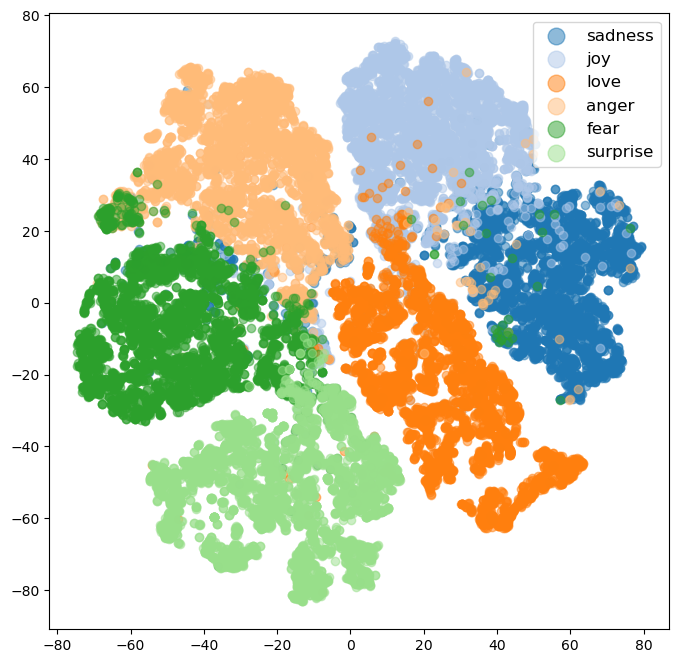

In [ ]:
# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(cpu_lstm[:,-1,:])
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = cpu_ys==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = emotion_map[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

#### 1.4.2 Visualize LSTM Embeddings

/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25910 samples in 0.013s...
[t-SNE] Computed neighbors for 25910 samples in 14.405s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25910
[t-SNE] Computed conditional probabilities for sample 2000 / 25910
[t-SNE] Computed conditional probabilities for sample 3000 / 25910
[t-SNE] Computed conditional probabilities for sample 4000 / 25910
[t-SNE] Computed conditional probabilities for sample 5000 / 25910
[t-SNE] Computed conditional probabilities for sample 6000 / 25910
[t-SNE] Computed conditional probabilities for sample 7000 / 25910
[t-SNE] Computed conditional probabilities for sample 8000 / 25910
[t-SNE] Computed conditional probabilities for sample 9000 / 25910
[t-SNE] Computed conditional probabilities for sample 10000 / 25910
[t-SNE] Computed conditional probabilities for sample 11000 / 25910
[t-SNE] Computed conditional probabilities for sample 12000 / 25910
[t-SNE] Computed conditional probabilities for sa

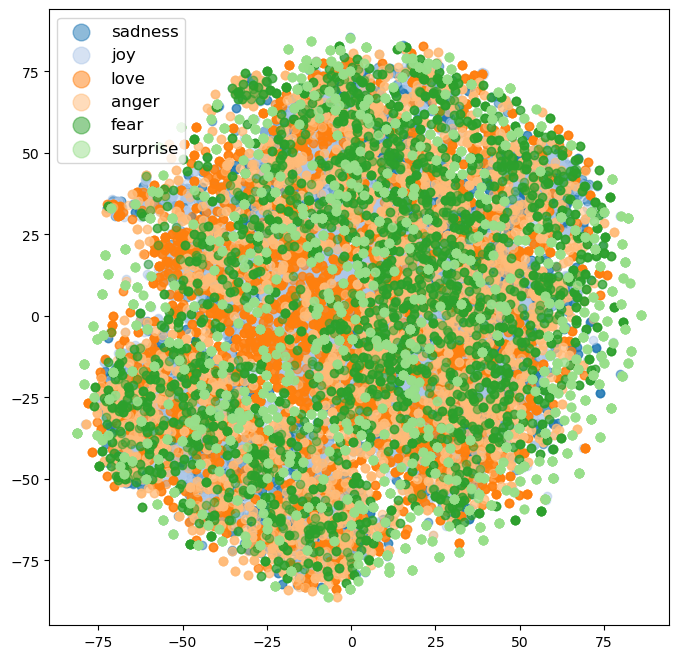

In [ ]:
# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(cpu_bs)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = cpu_ys==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = emotion_map[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

## Step 2: Construct BERT-LSTM Autoencoder

### 2.1 Train  BERT-LSTM Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=128, out_channels=output_size, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        x = self.decoder(encoded)
        return encoded, x

In [ ]:
input_size = 768 # size of BERT embeddings
output_size = 300 # size of GloVe/ LSTM embeddings

hidden_size = 128
model = Autoencoder(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare the input and output data
bert_embeddings = cpu_bs
lstm_embeddings = cpu_lstm[:,-1,:]
labels = cpu_ys
bert_tensor = torch.tensor(bert_embeddings).unsqueeze(2) # reshape to (num_embeddings, embedding_length, 1)
lstm_tensor = torch.tensor(lstm_embeddings).unsqueeze(2) # reshape to (num_embeddings, embedding_length, 1)

In [ ]:
num_epochs = 50
batch_size = 32

sampled_amount = math.floor(len(bert_tensor)*0.9)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(0, sampled_amount, batch_size):

        inputs = bert_tensor[i:i+batch_size]
        targets = lstm_tensor[i:i+batch_size]

        optimizer.zero_grad()

        encoded, outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss))
    torch.save(model.state_dict(), 'model/bert-lstm/size32/epoch-{}.pt'.format(epoch))


Epoch 1 loss: 70.608
Epoch 2 loss: 68.189
Epoch 3 loss: 67.215
Epoch 4 loss: 66.536
Epoch 5 loss: 65.554
Epoch 6 loss: 64.552
Epoch 7 loss: 63.581
Epoch 8 loss: 63.111
Epoch 9 loss: 62.642
Epoch 10 loss: 62.123
Epoch 11 loss: 61.869
Epoch 12 loss: 61.467
Epoch 13 loss: 61.291
Epoch 14 loss: 60.993
Epoch 15 loss: 60.452
Epoch 16 loss: 59.875
Epoch 17 loss: 59.535
Epoch 18 loss: 59.464
Epoch 19 loss: 59.299
Epoch 20 loss: 59.137
Epoch 21 loss: 58.997
Epoch 22 loss: 58.932
Epoch 23 loss: 58.758
Epoch 24 loss: 58.623
Epoch 25 loss: 58.653
Epoch 26 loss: 58.338
Epoch 27 loss: 57.837
Epoch 28 loss: 57.367
Epoch 29 loss: 57.047
Epoch 30 loss: 56.008
Epoch 31 loss: 55.764
Epoch 32 loss: 55.749
Epoch 33 loss: 55.576
Epoch 34 loss: 55.460
Epoch 35 loss: 55.413
Epoch 36 loss: 55.095
Epoch 37 loss: 54.920
Epoch 38 loss: 54.848
Epoch 39 loss: 54.719
Epoch 40 loss: 54.809
Epoch 41 loss: 54.556
Epoch 42 loss: 54.493
Epoch 43 loss: 54.446
Epoch 44 loss: 54.404
Epoch 45 loss: 54.234
Epoch 46 loss: 54.3

### 2.2 Generate Bottleneck and Reconstructed LSTM Embeddings 

In [ ]:
#load the model for early stopped epoch (epoch=20)
model = Autoencoder(input_size, hidden_size, output_size)
selected_epoch = 25
model.load_state_dict(torch.load('model/bert-lstm/size32/epoch-{}.pt'.format(selected_epoch)))

test_bert = bert_tensor[sampled_amount:]
bottleneck, outputs = model(test_bert)

#### 2.2.1 Visualize Bottleneck Embeddings 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2591 samples in 0.000s...


/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 2591 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2591
[t-SNE] Computed conditional probabilities for sample 2000 / 2591
[t-SNE] Computed conditional probabilities for sample 2591 / 2591
[t-SNE] Mean sigma: 0.216334
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.609055
[t-SNE] KL divergence after 1000 iterations: 0.939877


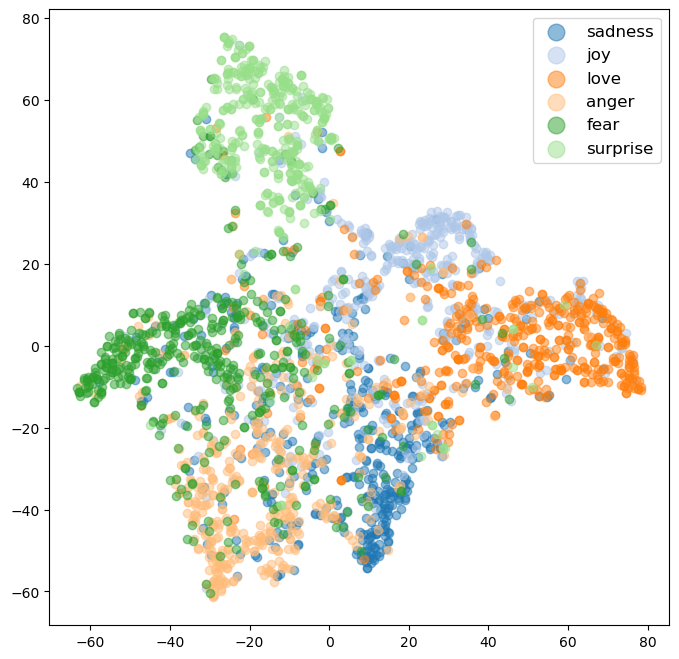

In [ ]:
bottleneck = bottleneck.squeeze()
bottleneck = bottleneck.detach().numpy()

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(bottleneck)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = cpu_ys[sampled_amount:]==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4),label = emotion_map[lab], alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

#### 2.2.2 Visualize Reconstructed LSTM Embeddings 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2591 samples in 0.001s...


/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 2591 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2591
[t-SNE] Computed conditional probabilities for sample 2000 / 2591
[t-SNE] Computed conditional probabilities for sample 2591 / 2591
[t-SNE] Mean sigma: 0.079370
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.991737
[t-SNE] KL divergence after 1000 iterations: 0.541153


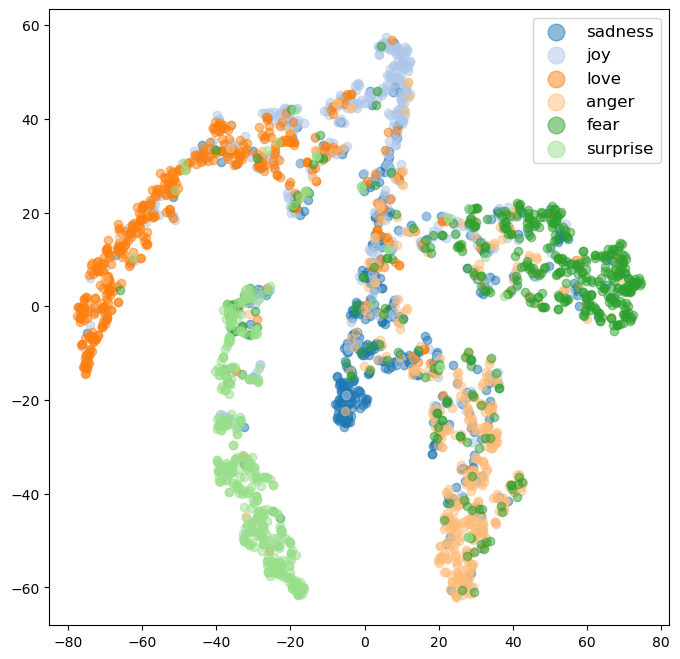

In [ ]:
outputs = outputs.squeeze()
outputs = outputs.detach().numpy()

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(outputs)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = cpu_ys[sampled_amount:]==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4),label = emotion_map[lab], alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

## Step 3: Representational Similarity Analysis

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import random

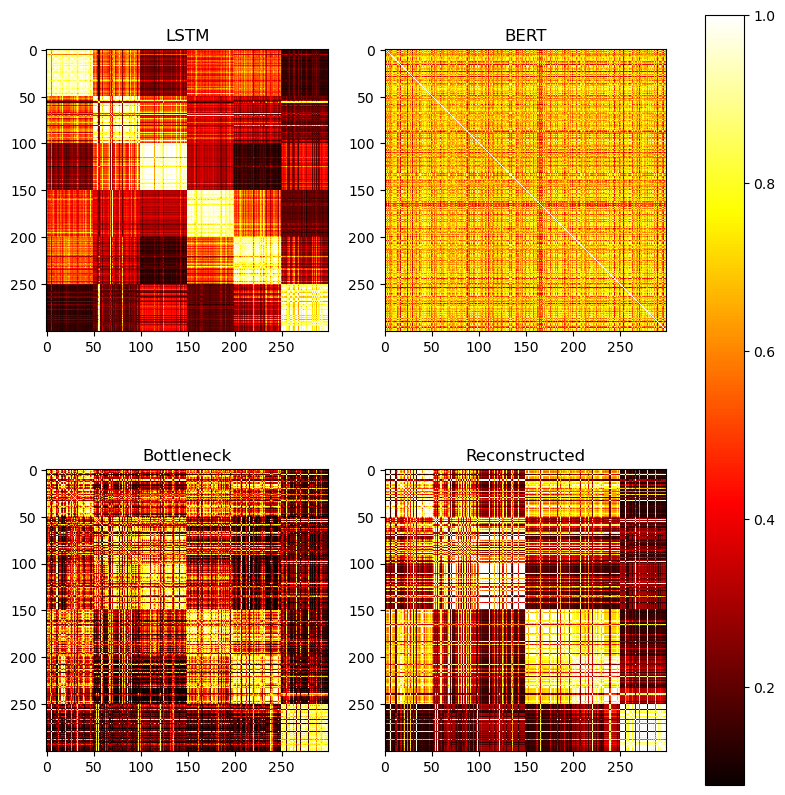

In [ ]:
num_classes = 6  # There are 6 classes (0 to 5)
samples_per_class = 50  # We want to sample 20 vectors from each class

sampled_lstm_vectors = []
sampled_bert_vectors = []
sampled_bottleneck_vectors = []
sampled_outputs_vectors = []
for i in range(num_classes):
    # Find the indices of vectors in the current class
    class_indices = torch.where(cpu_ys[sampled_amount:] == i)[0]
    # Sample 20 indices from the current class
    sample_indices = np.random.choice(class_indices, samples_per_class, replace=False)
    # Add the sampled vectors to the list
    sampled_lstm_vectors.append(cpu_lstm[sampled_amount:,-1,:][sample_indices])
    sampled_bert_vectors.append(cpu_bs[sampled_amount:][sample_indices])
    sampled_bottleneck_vectors.append(bottleneck[sample_indices])
    sampled_outputs_vectors.append(outputs[sample_indices])

# Concatenate the sampled vectors along the first dimension to create a tensor with shape (num_classes*samples_per_class, vector_size)
sampled_lstm_tensor = torch.cat(sampled_lstm_vectors, dim=0)
sampled_bert_tensor = torch.cat(sampled_bert_vectors, dim=0)

sampled_bottleneck_tensor = np.concatenate(sampled_bottleneck_vectors, axis=0).reshape((num_classes*samples_per_class, 32))
sampled_outputs_tensor = np.concatenate(sampled_outputs_vectors, axis=0).reshape((num_classes*samples_per_class, 300))

# Compute the cosine similarity matrix between the sampled vectors
from scipy.spatial.distance import cdist
cos_sim_matrix_lstm = 1 - cdist(sampled_lstm_tensor.numpy(), sampled_lstm_tensor.numpy(), metric='cosine')
cos_sim_matrix_bert = 1 - cdist(sampled_bert_tensor.numpy(), sampled_bert_tensor.numpy(), metric='cosine')
cos_sim_matrix_bottleneck = 1 - cdist(sampled_bottleneck_tensor, sampled_bottleneck_tensor, metric='cosine')
cos_sim_matrix_outputs = 1 - cdist(sampled_outputs_tensor, sampled_outputs_tensor, metric='cosine')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
im1 = axs[0, 0].imshow(cos_sim_matrix_lstm, cmap='hot', interpolation='nearest')
axs[0, 0].set_title('LSTM')
im2 = axs[0, 1].imshow(cos_sim_matrix_bert, cmap='hot', interpolation='nearest')
axs[0, 1].set_title('BERT')
im3 = axs[1, 0].imshow(cos_sim_matrix_bottleneck, cmap='hot', interpolation='nearest')
axs[1, 0].set_title('Bottleneck')
im4 = axs[1, 1].imshow(cos_sim_matrix_outputs, cmap='hot', interpolation='nearest')
axs[1, 1].set_title('Reconstructed')

fig.colorbar(im4, ax=axs.ravel().tolist())
plt.show()

In [ ]:
#Get the lower half of each matrix and flatten it
lower_half_lstm = [cos_sim_matrix_lstm[i,j] for i in range(cos_sim_matrix_lstm.shape[0]) for j in range(i) if j < i]
lower_half_bert = [cos_sim_matrix_bert[i,j] for i in range(cos_sim_matrix_bert.shape[0]) for j in range(i) if j < i]
lower_half_bottleneck = [cos_sim_matrix_bottleneck[i,j] for i in range(cos_sim_matrix_bottleneck.shape[0]) for j in range(i) if j < i]
lower_half_outputs = [cos_sim_matrix_outputs[i,j] for i in range(cos_sim_matrix_outputs.shape[0]) for j in range(i) if j < i]

In [ ]:
from scipy.stats import pearsonr
import pandas as pd

# Calculate pairwise Pearson correlation
sim_matrices = [lower_half_lstm, lower_half_bert, lower_half_bottleneck, lower_half_outputs]
corrs = []
for i in range(len(sim_matrices)):
    for j in range(i+1, len(sim_matrices)):
        corr, _ = pearsonr(sim_matrices[i], sim_matrices[j])
        corrs.append(corr)

table = pd.DataFrame({
    ' ': ['lstm', 'bert', 'bottleneck', 'outputs'],
    'lstm': ['-', corrs[0], corrs[1], corrs[2]],
    'bert': [corrs[0], '-', corrs[3], corrs[4]],
    'bottleneck': [corrs[1], corrs[3], '-', corrs[5]],
    'outputs': [corrs[2], corrs[4], corrs[5], '-']
}).set_index(' ')

print(table)


                lstm      bert bottleneck   outputs
                                                   
lstm               -  0.023923   0.518392   0.57019
bert        0.023923         -    0.09118  0.008041
bottleneck  0.518392   0.09118          -  0.809331
outputs      0.57019  0.008041   0.809331         -


##  Step 4: Manipulating Epoch Number and Bottleneck Size

### 4.1 Plot Pearson coefficient for all epochs 

In [ ]:
num_classes = 6  
samples_per_class = 50  
sampled_labels = []
for i in range(num_classes):
    class_indices = torch.where(cpu_ys[sampled_amount:] == i)[0]
    sample_indices = np.random.choice(class_indices, samples_per_class, replace=False)
    sampled_labels.append(sample_indices)

In [ ]:
def generate_pearson_corr(bottleneck, outputs, pearson_df):

    sampled_lstm_vectors = []
    sampled_bert_vectors = []
    sampled_bottleneck_vectors = []
    sampled_outputs_vectors = []
    for sample_indices in sampled_labels:
        #class_indices = torch.where(cpu_ys[sampled_amount:] == i)[0]
        #sample_indices = np.random.choice(class_indices, samples_per_class, replace=False)
        sampled_lstm_vectors.append(cpu_lstm[sampled_amount:,-1,:][sample_indices])
        sampled_bert_vectors.append(cpu_bs[sampled_amount:][sample_indices])
        sampled_bottleneck_vectors.append(bottleneck[sample_indices])
        sampled_outputs_vectors.append(outputs[sample_indices])

    sampled_lstm_tensor = torch.cat(sampled_lstm_vectors, dim=0)
    sampled_bert_tensor = torch.cat(sampled_bert_vectors, dim=0)
    sampled_bottleneck_tensor = np.concatenate(sampled_bottleneck_vectors, axis=0).reshape((num_classes*samples_per_class, bottleneck.shape[1]))
    sampled_outputs_tensor = np.concatenate(sampled_outputs_vectors, axis=0).reshape((num_classes*samples_per_class, 300))

    cos_sim_matrix_lstm = 1 - cdist(sampled_lstm_tensor.numpy(), sampled_lstm_tensor.numpy(), metric='cosine')
    cos_sim_matrix_bert = 1 - cdist(sampled_bert_tensor.numpy(), sampled_bert_tensor.numpy(), metric='cosine')
    cos_sim_matrix_bottleneck = 1 - cdist(sampled_bottleneck_tensor, sampled_bottleneck_tensor, metric='cosine')
    cos_sim_matrix_outputs = 1 - cdist(sampled_outputs_tensor, sampled_outputs_tensor, metric='cosine')
    
    lower_half_lstm = [cos_sim_matrix_lstm[i,j] for i in range(cos_sim_matrix_lstm.shape[0]) for j in range(i) if j < i]
    lower_half_bert = [cos_sim_matrix_bert[i,j] for i in range(cos_sim_matrix_bert.shape[0]) for j in range(i) if j < i]
    lower_half_bottleneck = [cos_sim_matrix_bottleneck[i,j] for i in range(cos_sim_matrix_bottleneck.shape[0]) for j in range(i) if j < i]
    lower_half_outputs = [cos_sim_matrix_outputs[i,j] for i in range(cos_sim_matrix_outputs.shape[0]) for j in range(i) if j < i]
    
    corr1, p1 = pearsonr(lower_half_bottleneck, lower_half_lstm)
    corr2, p2 = pearsonr(lower_half_bottleneck, lower_half_bert)
    corr3, p3 = pearsonr(lower_half_bottleneck, lower_half_outputs)
    corr4, p4 = pearsonr(lower_half_outputs, lower_half_lstm)
    corr5, p5 = pearsonr(lower_half_outputs, lower_half_bert)
    
    pearson_df.append([corr1, p1, corr2, p2, corr3, p3, corr4, p4, corr5, p5])

In [ ]:
pearsons = []

for i in range(50):
    model = Autoencoder(input_size, hidden_size, output_size)
    model.load_state_dict(torch.load('model/bert-lstm/size32/epoch-{}.pt'.format(i)))
    test_bert = bert_tensor[sampled_amount:]
    bottleneck, outputs = model(test_bert)
    
    bottleneck = bottleneck.squeeze()
    bottleneck = bottleneck.detach().numpy()
    outputs = outputs.squeeze()
    outputs = outputs.detach().numpy()

    generate_pearson_corr(bottleneck, outputs, pearsons)

In [ ]:
pearson_df = pd.DataFrame(np.vstack(pearsons))
pearson_df.columns =['Bottleneck X LSTM', 'p1', 'Bottleneck X BERT', 'p2', 'Bottleneck X Reconstructed', 'p3', 'Reconstructed X LSTM', 'p4', 'Reconstructed X BERT', 'p5']

In [ ]:
pearson_df.to_excel('pearson_df_size32_bert-lstm.xlsx')

Text(0, 0.5, 'Pearson Coefficient')

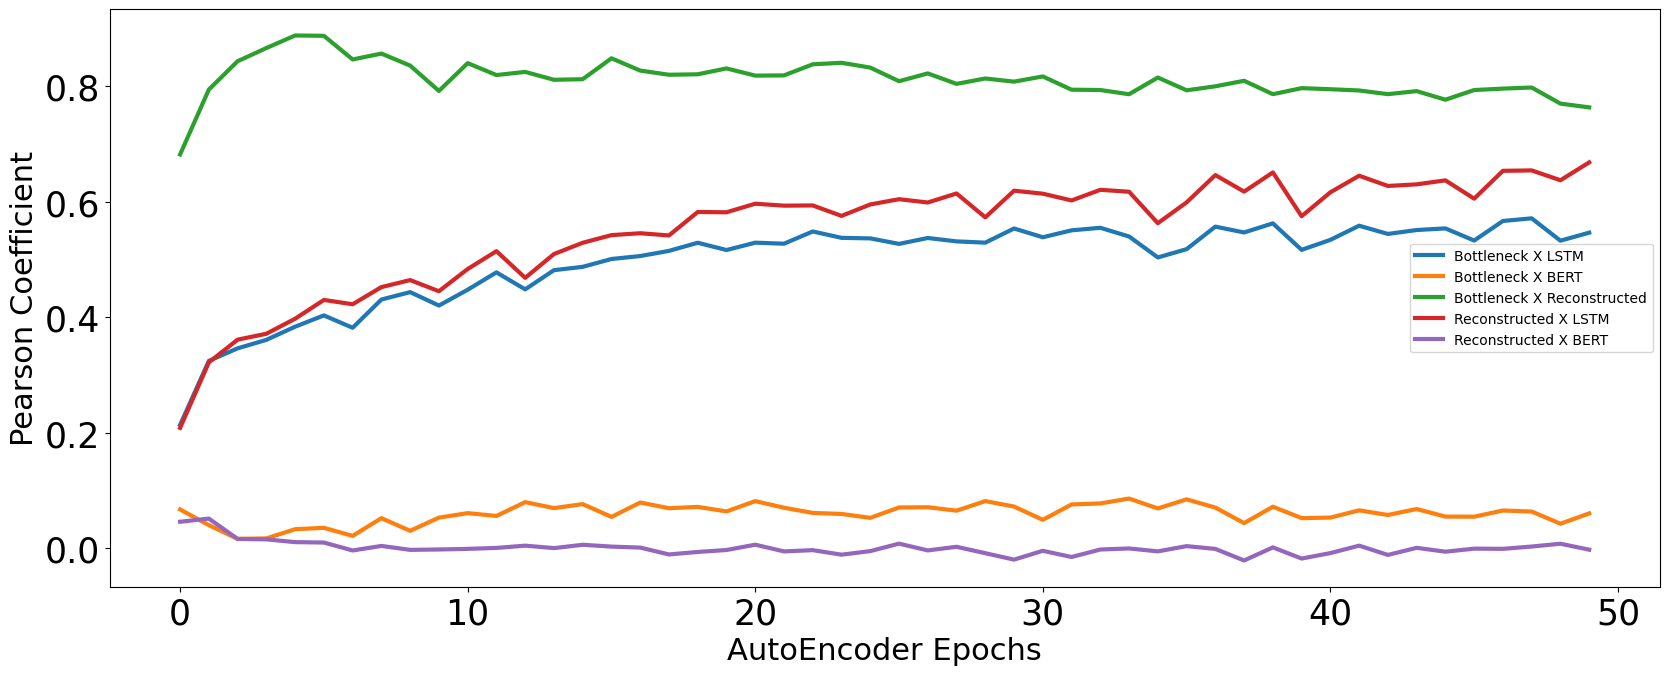

In [ ]:
ax = pearson_df[['Bottleneck X LSTM', 'Bottleneck X BERT','Bottleneck X Reconstructed', 'Reconstructed X LSTM', 'Reconstructed X BERT']].plot(figsize=(20,7.5), legend = True, linewidth=3)
#ax.set_title("Manipulate Epoch Numbers for Similarity Comparison", fontsize=30)
ax.tick_params(axis='x', which='both', labelsize=25)
ax.tick_params(axis='y', which='both', labelsize=25)
ax.set_xlabel('AutoEncoder Epochs',fontdict={'fontsize':22})
ax.set_ylabel('Pearson Coefficient',fontdict={'fontsize':22})

### 4.2 Manipulate Bottleneck Size 

In [ ]:
class Autoencoder64(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Autoencoder64, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=256, out_channels=output_size, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        x = self.decoder(encoded)
        return encoded, x

In [ ]:
class Autoencoder128(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Autoencoder128, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=256, out_channels=output_size, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        x = self.decoder(encoded)
        return encoded, x

In [ ]:
class Autoencoder256(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Autoencoder256, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=512, out_channels=384, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=384, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=256, out_channels=300, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=300, out_channels=300, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=300, out_channels=output_size, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        x = self.decoder(encoded)
        return encoded, x

In [ ]:
input_size = 768 
output_size = 300 

model = Autoencoder256(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

bert_embeddings = cpu_bs
lstm_embeddings = cpu_lstm[:,-1,:]
labels = cpu_ys
bert_tensor = torch.tensor(bert_embeddings).unsqueeze(2) 
lstm_tensor = torch.tensor(lstm_embeddings).unsqueeze(2) 

/tmp/ipykernel_1369584/2224689191.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bert_tensor = torch.tensor(bert_embeddings).unsqueeze(2)
/tmp/ipykernel_1369584/2224689191.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lstm_tensor = torch.tensor(lstm_embeddings).unsqueeze(2)


In [ ]:
num_epochs = 50
batch_size = 32

sampled_amount = math.floor(len(bert_tensor)*0.9)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(0, sampled_amount, batch_size):
        inputs = bert_tensor[i:i+batch_size]
        targets = lstm_tensor[i:i+batch_size]
        optimizer.zero_grad()
        encoded, outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss))
    torch.save(model.state_dict(), 'model/bert-lstm/size256/epoch-{}.pt'.format(epoch))

Epoch 1 loss: 69.180
Epoch 2 loss: 66.377
Epoch 3 loss: 64.824
Epoch 4 loss: 63.057
Epoch 5 loss: 61.093
Epoch 6 loss: 59.943
Epoch 7 loss: 58.915
Epoch 8 loss: 57.821
Epoch 9 loss: 57.089
Epoch 10 loss: 56.030
Epoch 11 loss: 55.452
Epoch 12 loss: 54.890
Epoch 13 loss: 54.394
Epoch 14 loss: 53.823
Epoch 15 loss: 53.421
Epoch 16 loss: 53.056
Epoch 17 loss: 52.631
Epoch 18 loss: 52.267
Epoch 19 loss: 52.178
Epoch 20 loss: 51.860
Epoch 21 loss: 51.561
Epoch 22 loss: 51.436
Epoch 23 loss: 50.949
Epoch 24 loss: 50.660
Epoch 25 loss: 50.230
Epoch 26 loss: 49.896
Epoch 27 loss: 49.725
Epoch 28 loss: 49.626
Epoch 29 loss: 48.995
Epoch 30 loss: 49.038
Epoch 31 loss: 49.133
Epoch 32 loss: 48.628
Epoch 33 loss: 48.580
Epoch 34 loss: 48.445
Epoch 35 loss: 48.042
Epoch 36 loss: 48.070
Epoch 37 loss: 47.709
Epoch 38 loss: 47.788
Epoch 39 loss: 47.714
Epoch 40 loss: 47.511
Epoch 41 loss: 47.384
Epoch 42 loss: 47.368
Epoch 43 loss: 47.204
Epoch 44 loss: 47.083
Epoch 45 loss: 46.896
Epoch 46 loss: 47.0

In [ ]:
pearsons = []

for i in range(50):
    model = Autoencoder256(input_size, hidden_size, output_size)
    model.load_state_dict(torch.load('model/bert-lstm/size256/epoch-{}.pt'.format(i)))
    test_bert = bert_tensor[sampled_amount:]
    bottleneck, outputs = model(test_bert)
    
    bottleneck = bottleneck.squeeze()
    bottleneck = bottleneck.detach().numpy()
    outputs = outputs.squeeze()
    outputs = outputs.detach().numpy()
    try:
        generate_pearson_corr(bottleneck, outputs, pearsons)
    except:
        print(i)

In [ ]:
pearson_df = pd.DataFrame(np.vstack(pearsons))
pearson_df.columns =['Bottleneck X LSTM', 'p1', 'Bottleneck X BERT', 'p2', 'Bottleneck X Reconstructed', 'p3', 'Reconstructed X LSTM', 'p4', 'Reconstructed X BERT', 'p5']

Text(0, 0.5, 'Pearson Coefficient')

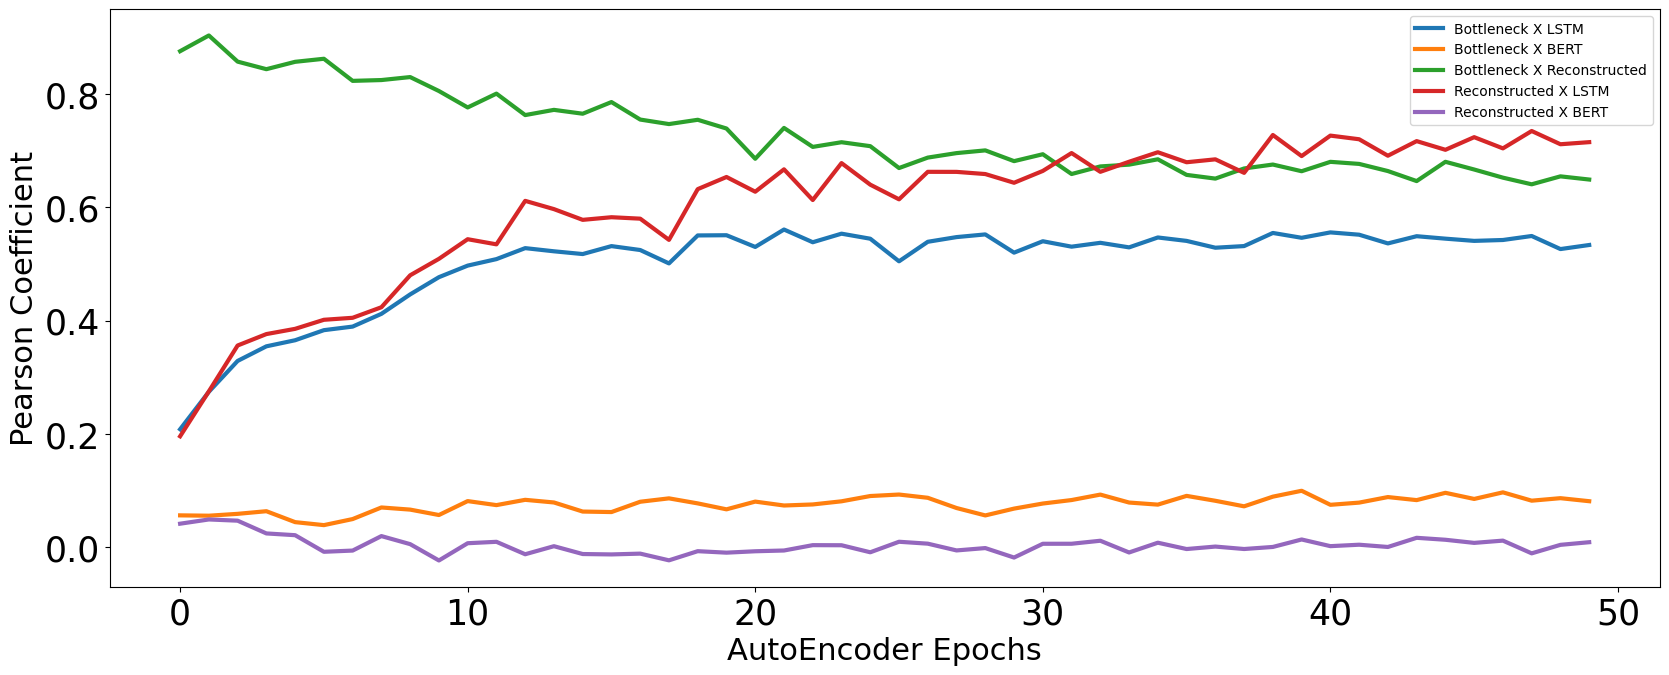

In [ ]:
ax = pearson_df[['Bottleneck X LSTM', 'Bottleneck X BERT','Bottleneck X Reconstructed', 'Reconstructed X LSTM', 'Reconstructed X BERT']].plot(figsize=(20,7.5), legend = True, linewidth=3)
#ax.set_title("Manipulate Epoch Numbers for Similarity Comparison", fontsize=30)
ax.tick_params(axis='x', which='both', labelsize=25)
ax.tick_params(axis='y', which='both', labelsize=25)
ax.set_xlabel('AutoEncoder Epochs',fontdict={'fontsize':22})
ax.set_ylabel('Pearson Coefficient',fontdict={'fontsize':22})

# Study 2: Generalizability: Comparing Embedding Performances on Different Tasks

In [ ]:
from datasets import load_dataset
dataset = load_dataset("tweets_hate_speech_detection")

Found cached dataset tweets_hate_speech_detection (/home/sbkim/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/d8cea5e82c610e1675eee6632345085d81875565ea46d24bdcd5a7f382e335ad)


  0%|          | 0/2 [00:00<?, ?it/s]

## 2.1 Data Collection and Preprocessing
### 2.1.1 Sample 4000 hate speech tweets 

In [ ]:
from sklearn.utils import resample
import numpy as np

train_labels = dataset['train']['label']
train_tweets = dataset['train']['tweet']

# Resample 3000 instances from each class
class_0_tweets = [train_tweets[i] for i in range(len(train_labels)) if train_labels[i] == 0]
class_1_tweets = [train_tweets[i] for i in range(len(train_labels)) if train_labels[i] == 1]
class_0_sample = resample(class_0_tweets, n_samples=2200, replace=False, random_state=42)
class_1_sample = resample(class_1_tweets, n_samples=2200, replace=False, random_state=42)

# Combine the sampled instances and their corresponding labels
sampled_tweets = np.concatenate((class_0_sample, class_1_sample))
sampled_labels = np.concatenate((np.zeros(2200), np.ones(2200)))

# Shuffle the sampled instances
shuffle_indices = np.arange(len(sampled_labels))
np.random.shuffle(shuffle_indices)
sampled_tweets = sampled_tweets[shuffle_indices]
sampled_labels = sampled_labels[shuffle_indices]

### 2.1.1 Preprocessing 

In [ ]:
import re

tweets = sampled_tweets

cleaned_tweets = []

for tweet in tweets:
    # Remove @user mentions
    tweet = re.sub(r'@[\w]+', '', tweet)
    
    # Remove foreign characters
    tweet = tweet.encode('ascii', 'ignore').decode('ISO-8859-1')
    
    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U0001F1F2-\U0001F1F4"  
        u"\U0001F1E6-\U0001F1FF"  
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    
    tweet = emoji_pattern.sub(r'', tweet)
    
    # Remove hashtags
    tweet = re.sub(r'#(\w+)', '', tweet)
    
    cleaned_tweets.append(tweet.strip())

### 2.1.2 Get all four embeddings

In [ ]:
glv_tokenizer = get_tokenizer("basic_english") 
#global_vectors = GloVe(name='6B', dim=300)
tweets_embedding = []
for text in cleaned_tweets:
    try:
        tweets_embedding.append(global_vectors.get_vecs_by_tokens(glv_tokenizer(text), lower_case_backup=True))
    except:
        #print('print')
        tweets_embedding.append([[0]*300])
#tweets_inputs = pad_sequence(tweets_embedding,batch_first=True)
tweets = padding(tweets_embedding, 300)
np.save("npy/new_task_lstm",tweets)
tweets= np.load("npy/new_task_lstm.npy", allow_pickle = True)
tweets.shape

(4400, 66, 300)

In [ ]:
from transformers import AutoTokenizer, AutoModel

#Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)

def get_bert_embeddings(sentences, batch_size=32):
    # Split the sentences into batches
    batches = [sentences[i:i + batch_size] for i in range(0, len(sentences), batch_size)]

    # Initialize a list to store the embeddings for all sentences
    all_embeddings = []

    # Process each batch
    for batch in batches:
        # Tokenize input sentences
        tokenized = bert_tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
        # Move tokenized data to device
        tokenized = tokenized.to(device)
        # Generate BERT embeddings
        with torch.no_grad():
            outputs = model(**tokenized)
            embeddings = outputs.last_hidden_state
        # Extract the [CLS] token embeddings
        sentence_embeddings = embeddings[:, 0, :]
        # Move embeddings to CPU and convert to a list
        sentence_embeddings = sentence_embeddings.to('cpu').detach().numpy().tolist()
        all_embeddings.extend(sentence_embeddings)

    return all_embeddings

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert = get_bert_embeddings(cleaned_tweets)

LSTM_model = LSTM(n_joints,n_hidden,n_categories,n_layer)
LSTM_model.load_state_dict(torch.load('model/main-lstm-model.pt'))
lstm_tensor = torch.tensor(tweets, dtype=torch.float)
LSTM_model(lstm_tensor)
lstm = LSTM_model.lstm_array[:,-1,:]

AE = Autoencoder(768, hidden_size, output_size)
AE.load_state_dict(torch.load('model/bert-lstm/size32/epoch-{}.pt'.format(25)))
bert = torch.tensor(bert, dtype=torch.float)
bert_tensor = torch.tensor(bert).unsqueeze(2)

bottleneck, outputs = AE(bert_tensor)

/tmp/ipykernel_1369584/2963346754.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bert_tensor = torch.tensor(bert).unsqueeze(2)


In [ ]:
lstm = lstm.detach().numpy()
bottleneck = bottleneck.squeeze()
bottleneck = bottleneck.detach().numpy()
outputs = outputs.squeeze()
outputs = outputs.detach().numpy()

### 2.1.3 Visualize pre-trained four embeddings 

In [ ]:
hate_map = {0: 'no-hate', 1: 'hate'}
hate_label = [hate_map[i] for i in sampled_labels.tolist()]

/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4400 samples in 0.002s...
[t-SNE] Computed neighbors for 4400 samples in 0.307s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4400
[t-SNE] Computed conditional probabilities for sample 2000 / 4400
[t-SNE] Computed conditional probabilities for sample 3000 / 4400
[t-SNE] Computed conditional probabilities for sample 4000 / 4400
[t-SNE] Computed conditional probabilities for sample 4400 / 4400
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.243263
[t-SNE] KL divergence after 1000 iterations: 2.110128
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4400 samples in 0.001s...


/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 4400 samples in 0.248s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4400
[t-SNE] Computed conditional probabilities for sample 2000 / 4400
[t-SNE] Computed conditional probabilities for sample 3000 / 4400
[t-SNE] Computed conditional probabilities for sample 4000 / 4400
[t-SNE] Computed conditional probabilities for sample 4400 / 4400
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.410065
[t-SNE] KL divergence after 1000 iterations: 0.775399
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4400 samples in 0.000s...


/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 4400 samples in 0.229s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4400
[t-SNE] Computed conditional probabilities for sample 2000 / 4400
[t-SNE] Computed conditional probabilities for sample 3000 / 4400
[t-SNE] Computed conditional probabilities for sample 4000 / 4400
[t-SNE] Computed conditional probabilities for sample 4400 / 4400
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.327446
[t-SNE] KL divergence after 1000 iterations: 1.266854
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4400 samples in 0.002s...


/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sbkim/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 4400 samples in 0.322s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4400
[t-SNE] Computed conditional probabilities for sample 2000 / 4400
[t-SNE] Computed conditional probabilities for sample 3000 / 4400
[t-SNE] Computed conditional probabilities for sample 4000 / 4400
[t-SNE] Computed conditional probabilities for sample 4400 / 4400
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.244377
[t-SNE] KL divergence after 1000 iterations: 2.107746


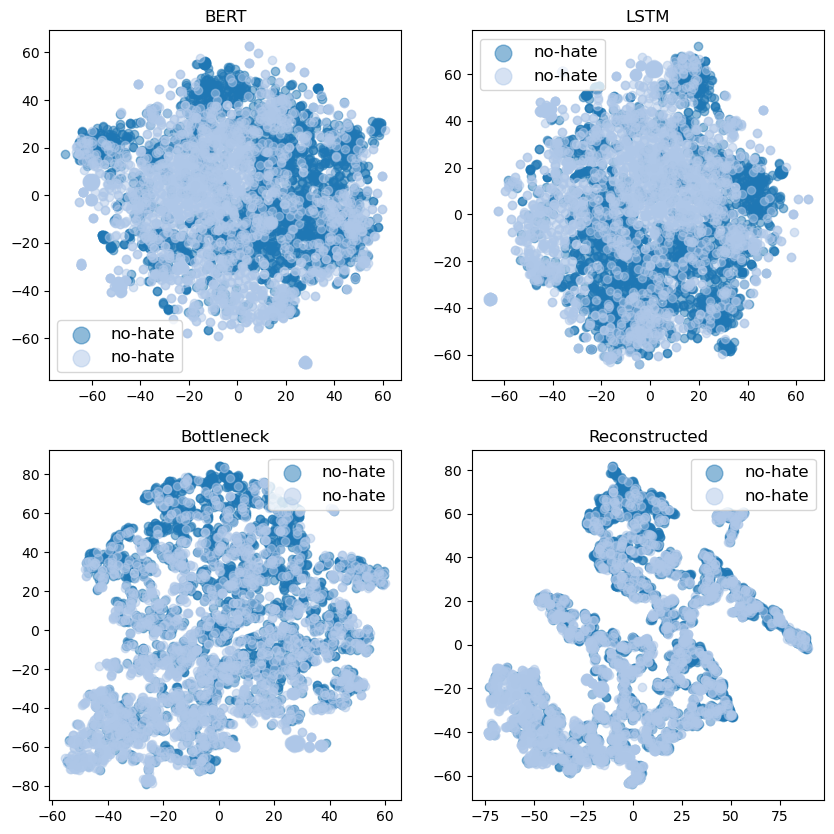

In [ ]:
# Define the TSNE model and fit_transform for all four embeddings
tsne = TSNE(2, verbose=1)
tsne_proj_bert = tsne.fit_transform(bert)
tsne_proj_output = tsne.fit_transform(outputs)
tsne_proj_bottleneck = tsne.fit_transform(bottleneck)
tsne_proj_lstm = tsne.fit_transform(bert)

# Define the color map
cmap = cm.get_cmap('tab20')

# Plot the scatter plots for all four embeddings
fig, axs = plt.subplots(2, 2, figsize=(10,10))

num_categories = 2
for lab in range(num_categories):
    indices = sampled_labels==lab
    axs[0, 0].scatter(tsne_proj_bert[indices,0], tsne_proj_bert[indices,1], c=np.array(cmap(lab)).reshape(1,4), label=hate_label[lab], alpha=0.5)
    axs[1, 1].scatter(tsne_proj_output[indices,0], tsne_proj_output[indices,1], c=np.array(cmap(lab)).reshape(1,4), label=hate_label[lab], alpha=0.5)
    axs[1, 0].scatter(tsne_proj_bottleneck[indices,0], tsne_proj_bottleneck[indices,1], c=np.array(cmap(lab)).reshape(1,4), label=hate_label[lab], alpha=0.5)
    axs[0, 1].scatter(tsne_proj_lstm[indices,0], tsne_proj_lstm[indices,1], c=np.array(cmap(lab)).reshape(1,4), label=hate_label[lab], alpha=0.5)

# Set the legends and show the plot
axs[0, 0].legend(fontsize='large', markerscale=2)
axs[0, 1].legend(fontsize='large', markerscale=2)
axs[1, 0].legend(fontsize='large', markerscale=2)
axs[1, 1].legend(fontsize='large', markerscale=2)

axs[0, 0].set_title('BERT')
axs[0, 1].set_title('LSTM')
axs[1, 0].set_title('Bottleneck')
axs[1, 1].set_title('Reconstructed')

plt.show()


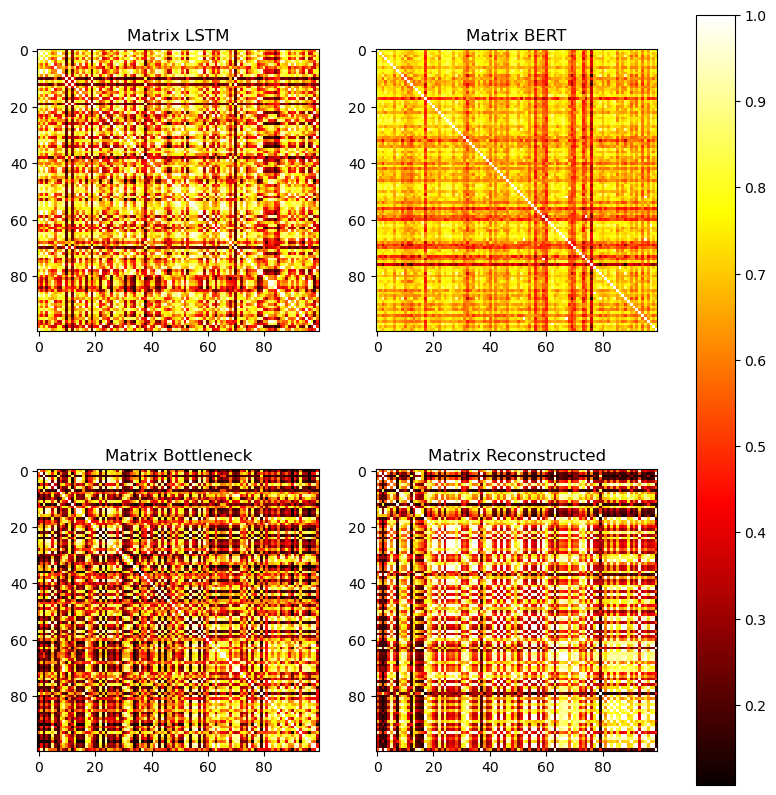

In [ ]:
num_classes = 2  # There are 6 classes (0 to 5)
samples_per_class = 50  # We want to sample 20 vectors from each class

sampled_lstm_vectors = []
sampled_bert_vectors = []
sampled_bottleneck_vectors = []
sampled_outputs_vectors = []
for i in range(num_classes):
    # Find the indices of vectors in the current class
    class_indices = np.where(sampled_labels == i)[0]
    # Sample 20 indices from the current class
    sample_indices = np.random.choice(class_indices, samples_per_class, replace=False)
    # Add the sampled vectors to the list
    sampled_lstm_vectors.append(lstm[sample_indices])
    sampled_bert_vectors.append(bert[sample_indices])
    sampled_bottleneck_vectors.append(bottleneck[sample_indices])
    sampled_outputs_vectors.append(outputs[sample_indices])

# Concatenate the sampled vectors along the first dimension to create a tensor with shape (num_classes*samples_per_class, vector_size)
#sampled_lstm_tensor = torch.cat(sampled_lstm_vectors, dim=0)
sampled_bert_tensor = torch.cat(sampled_bert_vectors, dim=0)
sampled_lstm_tensor = np.concatenate(sampled_lstm_vectors, axis=0).reshape((num_classes*samples_per_class, 300))

sampled_bottleneck_tensor = np.concatenate(sampled_bottleneck_vectors, axis=0).reshape((num_classes*samples_per_class, 32))
sampled_outputs_tensor = np.concatenate(sampled_outputs_vectors, axis=0).reshape((num_classes*samples_per_class, 300))

# Compute the cosine similarity matrix between the sampled vectors
from scipy.spatial.distance import cdist
cos_sim_matrix_lstm = 1 - cdist(sampled_lstm_tensor, sampled_lstm_tensor, metric='cosine')
cos_sim_matrix_bert = 1 - cdist(sampled_bert_tensor.numpy(), sampled_bert_tensor.numpy(), metric='cosine')
cos_sim_matrix_bottleneck = 1 - cdist(sampled_bottleneck_tensor, sampled_bottleneck_tensor, metric='cosine')
cos_sim_matrix_outputs = 1 - cdist(sampled_outputs_tensor, sampled_outputs_tensor, metric='cosine')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
im1 = axs[0, 0].imshow(cos_sim_matrix_lstm, cmap='hot', interpolation='nearest')
axs[0, 0].set_title('Matrix LSTM')
im2 = axs[0, 1].imshow(cos_sim_matrix_bert, cmap='hot', interpolation='nearest')
axs[0, 1].set_title('Matrix BERT')
im3 = axs[1, 0].imshow(cos_sim_matrix_bottleneck, cmap='hot', interpolation='nearest')
axs[1, 0].set_title('Matrix Bottleneck')
im4 = axs[1, 1].imshow(cos_sim_matrix_outputs, cmap='hot', interpolation='nearest')
axs[1, 1].set_title('Matrix Reconstructed')

# Create color bar
fig.colorbar(im4, ax=axs.ravel().tolist())
plt.show()

## 2.2 FCN for Hate Speech Classification 

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Define the fully connected network architecture
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         return out

        # Check if input tensor has 2 dimensions (batch size x input size)
        if len(x.shape) == 2:
            out = self.fc1(x)
        # If input tensor has 3 dimensions (batch size x sequence length x input size),
        # flatten the tensor before passing it to the linear layer
        
        elif len(x.shape) == 3:
            batch_size, seq_len, input_size = x.shape
            out = self.fc1(x.view(batch_size * seq_len, input_size))
            out = out.view(batch_size, seq_len, -1)
        else:
            raise ValueError("Input tensor must have 2 or 3 dimensions.")
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the training function
def train(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    return train_loss / len(dataloader.dataset)

# Define the evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return eval_loss / len(dataloader.dataset), correct / total

# Define the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the hyperparameters
input_sizes = {"lstm": 300, "bert": 768, "bottleneck": 32, "reconstruct": 300}
hidden_size = 100
num_classes = 2
learning_rate = 0.001
num_epochs = 20
batch_size = 32

sampled_inputs = {"lstm": lstm, "bert": bert, "bottleneck": bottleneck, "reconstruct": outputs}
train_dataloaders = {}
val_dataloaders = {}
for input_type in input_sizes.keys():
    X_train, X_val, y_train, y_val = train_test_split(
        sampled_inputs[input_type], sampled_labels, test_size=0.2, random_state=42
    )

    X_train, X_val = torch.Tensor(X_train).to(device), torch.Tensor(X_val).to(device)
    y_train, y_val = torch.LongTensor(y_train).to(device), torch.LongTensor(y_val).to(device)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_dataloaders[input_type] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloaders[input_type] = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


models = {}
optimizers = {}
for input_type in input_sizes.keys():
    models[input_type] = FCNet(input_sizes[input_type], hidden_size, num_classes).to(device)
    optimizers[input_type] = optim.Adam(models[input_type].parameters(), lr=learning_rate)

performance = {'Train Loss': [], 
              'Val Loss':[], 
              'Val Acc':[]}
# Train and evaluate each model
for input_type, model in models.items():
    print(f"Training model with {input_type} input...")
    print(model)
    for epoch in range(num_epochs):
        train_loss = train(model, train_dataloaders[input_type], nn.CrossEntropyLoss(), optimizers[input_type])
        val_loss, val_acc = evaluate(model, val_dataloaders[input_type], nn.CrossEntropyLoss())
        if epoch == num_epochs-1:
            performance['Train Loss'].append(train_loss)
            performance['Val Loss'].append(val_loss)
            performance['Val Acc'].append(val_acc)
            
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")


Training model with lstm input...
FCNet(
  (fc1): Linear(in_features=300, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)
Epoch 1: Train Loss = 0.6580, Val Loss = 0.6453, Val Acc = 0.6295
Epoch 2: Train Loss = 0.6493, Val Loss = 0.6433, Val Acc = 0.6295
Epoch 3: Train Loss = 0.6402, Val Loss = 0.6415, Val Acc = 0.6295
Epoch 4: Train Loss = 0.6414, Val Loss = 0.6388, Val Acc = 0.6398
Epoch 5: Train Loss = 0.6364, Val Loss = 0.6384, Val Acc = 0.6364
Epoch 6: Train Loss = 0.6334, Val Loss = 0.6420, Val Acc = 0.6227
Epoch 7: Train Loss = 0.6336, Val Loss = 0.6392, Val Acc = 0.6250
Epoch 8: Train Loss = 0.6307, Val Loss = 0.6353, Val Acc = 0.6466
Epoch 9: Train Loss = 0.6277, Val Loss = 0.6304, Val Acc = 0.6477
Epoch 10: Train Loss = 0.6263, Val Loss = 0.6375, Val Acc = 0.6341
Epoch 11: Train Loss = 0.6244, Val Loss = 0.6272, Val Acc = 0.6534
Epoch 12: Train Loss = 0.6207, Val Loss = 0.6318, Val Acc = 0.6352
Epoch 13: Train Loss = 

### 2.2.1 Baseline FCN Model

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

basic_tokenizer = get_tokenizer('basic_english')

def tokenize_tweets(tweets):
    return [basic_tokenizer(tweet) for tweet in tweets]

tokenized_tweets = tokenize_tweets(cleaned_tweets)

def yield_tokens(tokenized_tweets):
    for tokens in tokenized_tweets:
        yield tokens

vocab = build_vocab_from_iterator(yield_tokens(tokenized_tweets))

# 3. Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tokenized_tweets, sampled_labels, test_size=0.2, random_state=42)

# 4. Create a dataset class
class TweetDataset(Dataset):
    def __init__(self, tokenized_tweets, labels, vocab, max_length=128):
        self.tokenized_tweets = tokenized_tweets
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.tokenized_tweets)

    def __getitem__(self, idx):
        tweet = self.tokenized_tweets[idx]
        label = self.labels[idx]
        vector = torch.zeros(self.max_length, dtype=torch.long)

        for i, token in enumerate(tweet[:self.max_length]):
            vector[i] = self.vocab[token]

        return vector, torch.tensor(label, dtype=torch.float)

# 5. Create training and validation DataLoaders
batch_size = 32
train_dataset = TweetDataset(X_train, y_train, vocab)
val_dataset = TweetDataset(X_val, y_val, vocab)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 6. Define the neural network architecture
class FullyConnectedClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(FullyConnectedClassifier, self).__init__()
        self.embedding = nn.Embedding(len(vocab), input_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x.squeeze()




4400lines [00:00, 559630.58lines/s]


In [ ]:
from sklearn.metrics import accuracy_score
# 7. Train the model and report training loss
input_size = 128
hidden_size = 100
num_epochs = 20
learning_rate = 1e-4

model = FullyConnectedClassifier(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_losses = []
    model.train()
    for i, (tweets, labels) in enumerate(train_dataloader):
        outputs = model(tweets)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

    # 8. Evaluate the model and report validation loss and accuracy
    model.eval()
    val_losses, y_true, y_pred = [], [], []
    with torch.no_grad():
        for tweets, labels in val_dataloader:
            outputs = model(tweets)
            preds = (outputs > 0.5).float()
            loss = criterion(outputs, labels)

            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    val_accuracy = accuracy_score(y_true, y_pred)
    if epoch == num_epochs-1:
        performance['Train Loss'].append(train_loss)
        performance['Val Loss'].append(val_loss)
        performance['Val Acc'].append(val_accuracy)
        print(epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch [1/20], Train Loss: 0.6937
Epoch [1/20], Val Loss: 0.6934, Val Accuracy: 0.4875
Epoch [2/20], Train Loss: 0.6936
Epoch [2/20], Val Loss: 0.6931, Val Accuracy: 0.4909
Epoch [3/20], Train Loss: 0.6930
Epoch [3/20], Val Loss: 0.6918, Val Accuracy: 0.5125
Epoch [4/20], Train Loss: 0.6925
Epoch [4/20], Val Loss: 0.6914, Val Accuracy: 0.5136
Epoch [5/20], Train Loss: 0.6922
Epoch [5/20], Val Loss: 0.6948, Val Accuracy: 0.4875
Epoch [6/20], Train Loss: 0.6921
Epoch [6/20], Val Loss: 0.6943, Val Accuracy: 0.4875
Epoch [7/20], Train Loss: 0.6921
Epoch [7/20], Val Loss: 0.6913, Val Accuracy: 0.6148
Epoch [8/20], Train Loss: 0.6918
Epoch [8/20], Val Loss: 0.6921, Val Accuracy: 0.4932
Epoch [9/20], Train Loss: 0.6912
Epoch [9/20], Val Loss: 0.6913, Val Accuracy: 0.5500
Epoch [10/20], Train Loss: 0.6907
Epoch [10/20], Val Loss: 0.6903, Val Accuracy: 0.5807
Epoch [11/20], Train Loss: 0.6902
Epoch [11/20], Val Loss: 0.6919, Val Accuracy: 0.4920
Epoch [12/20], Train Loss: 0.6899
Epoch [12/20], V

In [ ]:
pd.DataFrame(performance).to_excel('hate_speech_performance_bert-lstm.xlsx')